# New Strategy

In [1]:
# PLAN
   # Get text with reddit api from conservative and liberal subreddits and store all texts in array
   # mark if its republican or democrat in pandas dataframe based on the subreddit
   # Do countvectorizer on array to create each column in a dataframe
   # Train logistic regression model
   # For user-inputted text, use original vectorizer to transform the dataset
   # Use the array returned as input to the model

# Possible Improvement
   # Use tf_idf and remove stop words from model

In [13]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import praw
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [14]:
reddit = praw.Reddit(
    client_id = os.getenv("REDDIT_CLIENT_ID"),
    client_secret = os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent = "PoliticalAnalysis",
)

conservative_subreddit = reddit.subreddit("conservative")
liberal_subreddit = reddit.subreddit("liberal")

liberal_comments = []
conservative_comments = []

for submission in liberal_subreddit.top(limit=40):
    for index, comment in enumerate(submission.comments):
        liberal_comments.append(comment.body)
        if index == 10:
            break
        
for submission in conservative_subreddit.top(limit=40):
    for index, comment in enumerate(submission.comments):
        conservative_comments.append(comment.body)
        if index == 10:
            break

In [15]:
print(len(liberal_comments))
print(len(conservative_comments))

432
440


In [16]:
stop_words = []

with open("stopwords.txt", "r") as f:
    words = f.read().splitlines()
    stop_words = words
    
stop_words[0:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

In [17]:
vectorizer = CountVectorizer(stop_words=stop_words, token_pattern="[a-zA-Z]+")
rows = vectorizer.fit_transform(liberal_comments+conservative_comments).toarray()
feature_names = vectorizer.get_feature_names()

data = pd.DataFrame(data=rows, columns=feature_names)

sums = np.sum(data).sort_values(ascending=False)
pd.DataFrame(sums).head(20)

,0
people,147
trump,146
conservative,68
vote,64
us,58
time,56
party,52
now,51
right,50
discord,50


In [18]:
# Create classification labels for conservatives and liberals that are the same length as their respective comment arrays
conservative_classifiers = np.full((len(conservative_comments), 1), "CONSERVATIVE")   # 1 for conservative
liberal_classifiers = np.full((len(liberal_comments), 1), "LIBERAL")           # 0 for liberal

# stack the two classifier arrays together to make one array and set it as a new column
data["Political_Party"] = np.vstack((conservative_classifiers, liberal_classifiers))
data.head()

,aae,ab,abandon,abducted,abhorren,abhorrent,ability,able,abo,abode,...,youtu,youtube,yrs,zealot,zealously,zero,zhiqiang,zip,zuckerberg,Political_Party
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CONSERVATIVE
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CONSERVATIVE
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CONSERVATIVE
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CONSERVATIVE
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CONSERVATIVE


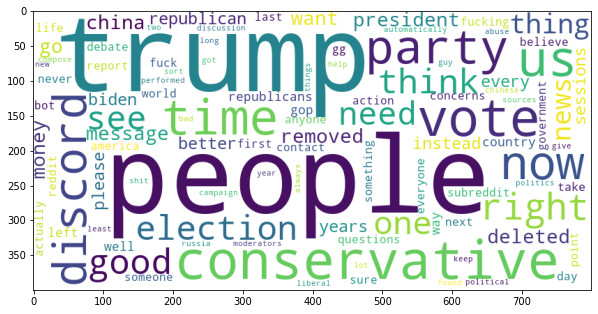

In [19]:
X_data = data.drop("Political_Party", axis=1)
frequencies = pd.DataFrame(X_data.sum(), columns=["counts"])
freqDict = frequencies.to_dict()['counts']

wc = WordCloud(width=800, height=400, max_words=100, background_color="white").generate_from_frequencies(freqDict)

plt.figure(figsize=(10,10))
plt.imshow(wc)

# Hyperparameter Tuning, Training Model, and Creating Pipeline

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# hide convergence warning from GridSearchCV
warnings.simplefilter("ignore", category=ConvergenceWarning)

X_data = data.drop("Political_Party", axis=1)
y_data = data["Political_Party"]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=20)

parameters = {
    "penalty":("l1", "l2"),
    "C": np.linspace(0.1,1.0,5),
    "solver": ("liblinear", "saga"),
}

model = LogisticRegression()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)

clf.best_params_

{'C': 0.325, 'penalty': 'l2', 'solver': 'liblinear'}

In [21]:
# Create pipeline and test model

test_comments = ["We’re lucky to have Dr. Fauci.", "We helped Afghanistan in their first election by dying people’s finger purple to prevent vote fraud. Why isn’t that an option here? I mean that seriously. Anyone can and should be able to walk into any polling station and vote. Period. If there’s concern they would vote more than once dye their finger purple with a dye that has to wear off. Problem solved.", "It would be nice; but if there's one thing we've all learned over the last couple of decades, it's that there is no justice in this country any more. Nothing will happen to her or the Clinton Cronies."]
pipe = make_pipeline(vectorizer, clf)
print(pipe.predict(test_comments))
print(pipe.predict_proba(test_comments))

['CONSERVATIVE' 'CONSERVATIVE' 'LIBERAL']
[[0.51220419 0.48779581]
 [0.67851407 0.32148593]
 [0.47910411 0.52089589]]


# Model Accuracy

In [22]:
from sklearn.metrics import f1_score

yhat = clf.predict(X_test)
f1_score(y_test, yhat, average="weighted")


0.6931692899195002

# Saving Model with Pickle

In [23]:
import pickle

with open("./pipe.pkl", "wb") as f:
    pickle.dump(pipe, f);